<a href="https://colab.research.google.com/github/Altemir1/Machine_learning/blob/main/MiDaS_2dto3d_converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
image_name="chair"

In [ ]:
!pip install timm torch torchvision

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


Current Working Directory: /content


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


True


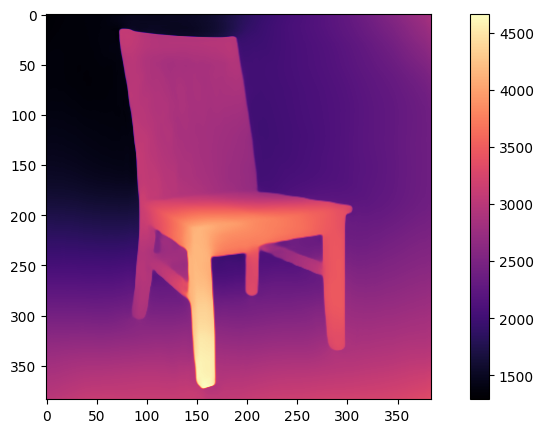

In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, normalize
import os
# Load the MiDaS model
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")
midas.eval()
print("Current Working Directory:", os.getcwd())
# Load transformer to resize and normalize the image for the model
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if torch.cuda.is_available():
    midas.to('cuda')
    device = 'cuda'
else:
    device = 'cpu'

transform = midas_transforms.default_transform

# Load your image
def load_image(image_path):

    img = cv2.imread(image_path)
    print(os.path.exists(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (384, 384), interpolation=cv2.INTER_AREA)
    img_tensor = to_tensor(img).unsqueeze(0)  # Add batch dimension
    img_tensor = normalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return img_tensor

image_path = 'chair.png'  # Replace with your actual file path
image = load_image(image_path)

# Predict the depth
with torch.no_grad():
    input_batch = image.to(device)
    prediction = midas(input_batch)

    # Resize to original dimensions
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=image.shape[2:],
        mode="bilinear",
        align_corners=False,
    ).squeeze()

# Convert the prediction to a displayable format
depth_map = prediction.cpu().numpy()

# Display the depth map
plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='magma')
plt.colorbar()  # Show color bar
plt.show()

In [ ]:
!pip install open3d

In [ ]:
import numpy as np
import open3d as o3d

# Assuming 'depth_map' is your depth map array
# You might want to adjust this normalization based on your specific depth range
depth_map_normalized = depth_map / np.max(depth_map)

# Generating a mesh grid
height, width = depth_map.shape
x, y = np.meshgrid(np.linspace(-1, 1, width), np.linspace(-1, 1, height))

# Flattening the arrays and stacking them into a 3D point format
z = depth_map_normalized.flatten()  # Depth values
points = np.stack((x.flatten(), y.flatten(), z), axis=-1)

# Create a point cloud object
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

# Optional: Estimate normals
point_cloud.estimate_normals()

# Use Poisson surface reconstruction as an alternative
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=9)[0]

# Save the mesh to an OBJ file
o3d.io.write_triangle_mesh(image_name+".obj", mesh, write_vertex_normals=True)

# Optional: Visualize the point cloud or mesh within the notebook
o3d.visualization.draw_geometries([mesh])  # Visualize the mesh

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
from google.colab import files
files.download(image_name+'.obj')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>